# Fig 1: SWOT in the Gulf Stream
This notebook has the code necessary to reproduce Figure 1 in *Villas Bôas, Marechal, and A Bohé, (2025)*

In [1]:
import sys
sys.path.insert(0, '../src')
from src import *

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

import cmocean

### Load observations and model output

In [2]:
date_SWOT = np.datetime64('2023-09-02T04:00')
lon_min, lon_max, lat_min, lat_max = -80, -70, 31, 40

# SWOT
ds_SWOT = xr.open_dataset('../data/SWOT/SWOT_GS.nc')
ds_SWOT_HS = xr.open_dataset('../data/SWOT/SWOT_HS_GS.nc')

# Models
ds_ww3 = xr.open_dataset('../data/WW3/WW3_GS_HYCOM_outputs.nc')
ds_ww3_nocur = xr.open_dataset('../data/WW3/WW3_GS_CTRL_outputs.nc')

# SWIM
ds_SWIM_ribbons = xr.open_dataset('../data/SWIM_offnadir/spec_GS_SWIM_L2S.nc')
ds_SWIM_alti = xr.open_dataset('../data/SWIM_alti/alti_GS_SWIM.nc')

In [3]:
# Prepare axis and variables to plot

# Wind Speed
wind_speed = (ds_ww3.uwnd**2 + ds_ww3.vwnd**2)**(1/2) 
# Current Speed Model
current_speed = (ds_ww3.ucur**2 + ds_ww3.vcur**2)**(1/2)
# Current Speed SWOT
u_speed_swot = (ds_SWOT.geo_zonal_current**2 + ds_SWOT.geo_meridional_current**2)**(1/2)

LON_HYCOM, LAT_HYCOM = np.meshgrid(ds_ww3.longitude.values, ds_ww3.latitude.values)

# Apply mask for speed threshold to be used by quiver
n_quiver = 1
ugos_masked = np.ma.masked_where(current_speed<.7, ds_ww3.ucur.values.squeeze())
vgos_masked = np.ma.masked_where(current_speed<.7, ds_ww3.vcur.values.squeeze())

### Compute bulk wave parameters from SWIM spectra

In [4]:
theta_SWIM = ds_SWIM_ribbons.phi_geo[:].values * np.pi/180 
wavenumber_SWIM = ds_SWIM_ribbons.k.values
spec_SWIM = (ds_SWIM_ribbons.wave_spectra[:, :]*(ds_SWIM_ribbons.k.values)**(-1)).values.T

# Compute Bulk
print(f'The Bulk from SWIM are:')
print(f'________________________')
print('\n')

# Compute Bulk and wave spectrum from SWIM
theta_swim, sub_k, e_kth, Lp, Dp, the_mp, sigp, Qp, Qkk = compute_bulk_l2s_SWIM(ds_SWIM_ribbons, 15) 

The Bulk from SWIM are:
________________________


Qkk = 20.253721568759634 m
Peak Wavelength = 168.13374 m
Peak Direction = 39.70597 deg


### Plot fields using Cartopy 

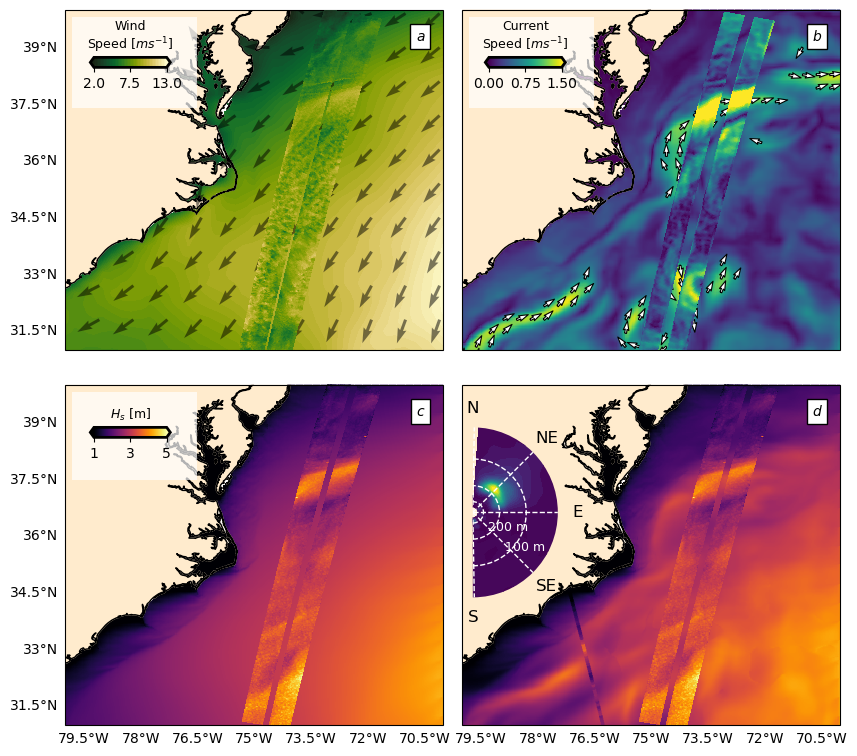

In [5]:
# Wind Speed

# Define vmin and vmax for the wind
vmin = 2
vmax = 13
# Subsample for quiver
n_quiver = 30 

fig = plt.figure(figsize = (10, 10))

# Create Cartopy axes
ax = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree()) 
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.0, linestyle='--', zorder=1)

# Create features
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

# Add features
ax.add_feature(cfeature.LAND,zorder=2,color='blanchedalmond')
ax.add_feature(cfeature.COASTLINE, zorder = 4)

# Activate and deactivate labels
gl.right_labels =False
gl.left_labels = True
gl.bottom_labels = False
gl.top_labels = False

# Add plot
p1 = ax.contourf(ds_ww3.longitude, ds_ww3.latitude, wind_speed, np.linspace(vmin, vmax, 50), extend = 'both', cmap =  cmocean.cm.speed_r)
ax.pcolor(ds_SWOT.longitude, ds_SWOT.latitude, ds_SWOT.wind_speed, vmin = vmin, vmax = vmax, cmap = cmocean.cm.speed_r, zorder = 4)
ax.quiver(ds_ww3.longitude[::n_quiver], ds_ww3.latitude[::n_quiver], ds_ww3.uwnd[::n_quiver,::n_quiver]/wind_speed[::n_quiver,::n_quiver], ds_ww3.vwnd[::n_quiver,::n_quiver]/wind_speed[::n_quiver,::n_quiver],\
         scale = 15, width = 0.008, alpha = .5, zorder = 3)

ax.text(.95, .9, 'a', transform=ax.transAxes, ha='right', va='bottom', 
         style='italic', bbox={'facecolor':'white', 'alpha':1})

# Colorbar settings
cbbox = inset_axes(ax, '33%', '27%', loc = 2)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.set_facecolor([1,1,1,.7])
cbbox.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

cax = fig.add_axes([.15, .795, 0.08, 0.01])

cbar = plt.colorbar(p1, cax = cax, orientation = 'horizontal', extend = 'both', ticks = [vmin, (vmin+vmax)/2, vmax])
cbar.outline.set_linewidth(2)
cbar.ax.set_title('Wind\nSpeed [$ms^{-1}$]', fontsize = 9)


########################################
# Current Speed 

# Define vmin and vmax for the currents
vmin = 0
vmax = 1.5
# Subsample for quiver
n_quiver = 12

# Create Cartopy axes
ax = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree()) 
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.0, linestyle='--', zorder=1)

# Create features
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

# Add features
ax.add_feature(cfeature.LAND,zorder=2,color='blanchedalmond')
ax.add_feature(cfeature.COASTLINE, zorder = 4)

# Activate and deactivate labels
gl.right_labels =False
gl.left_labels =False
gl.bottom_labels =False
gl.top_labels =False

# Add plot
p1 = ax.pcolor(ds_ww3.longitude, ds_ww3.latitude, current_speed, vmin = vmin, vmax = vmax, cmap = 'viridis')
ax.quiver(LON_HYCOM[::n_quiver, ::n_quiver], LAT_HYCOM[::n_quiver, ::n_quiver], ugos_masked[::n_quiver, ::n_quiver]/current_speed[::n_quiver, ::n_quiver], vgos_masked[::n_quiver, ::n_quiver]/current_speed[::n_quiver, ::n_quiver], scale = 30, width = 0.005, facecolor = 'w', edgecolor = 'k', linewidth = .8)
ax.pcolor(ds_SWOT.longitude, ds_SWOT.latitude, u_speed_swot, vmin = vmin, vmax = vmax, cmap = 'viridis', zorder = 3)

ax.text(.95, .9, 'b', transform=ax.transAxes, ha='right', va='bottom', 
         style='italic', bbox={'facecolor':'white', 'alpha':1})

# Colorbar settings
cbbox = inset_axes(ax, '33%', '27%', loc = 2)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.set_facecolor([1,1,1,.7])
cbbox.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

cax = fig.add_axes([.545, .795, 0.08, 0.01])

cbar = plt.colorbar(p1, cax = cax, orientation = 'horizontal', extend = 'both', ticks = [vmin, (vmin+vmax)/2, vmax])
cbar.outline.set_linewidth(2)
cbar.ax.set_title('Current\nSpeed [$ms^{-1}$]', fontsize = 9)


########################################
# Significant Wave Height (CTRL) 

# Define vmin and vmax for Hs
vmin = 1
vmax = 5

# Create Cartopy axes
ax = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.0, linestyle='--', zorder=1)

# Create features
ax.add_feature(cfeature.LAND,zorder=2,color='blanchedalmond')
ax.add_feature(cfeature.COASTLINE, zorder = 4)

# Activate and deactivate labels
gl.right_labels =False
gl.left_labels = True
gl.bottom_labels = True
gl.top_labels =False

# Add plot
p1 = ax.pcolor(ds_ww3_nocur.longitude, ds_ww3_nocur.latitude, ds_ww3_nocur.hs, vmin = vmin, vmax = vmax, cmap = 'inferno')
ax.contourf(ds_SWOT_HS.reference_longitude, ds_SWOT_HS.reference_latitude, ds_SWOT_HS['swh_2Dmap_2.0km'], np.linspace(vmin, vmax, 100), cmap = 'inferno')

ax.text(.95, .9, 'c', transform=ax.transAxes, ha='right', va='bottom', 
         style='italic', bbox={'facecolor':'white', 'alpha':1})

# Colorbar settings
cbbox = inset_axes(ax, '33%', '26%', loc = 2)
[cbbox.spines[k].set_visible(False) for k in cbbox.spines]
cbbox.set_facecolor([1,1,1,.7])
cbbox.tick_params(axis='both', which='both', length=0, labelbottom=False, labelleft=False)

cax = fig.add_axes([.15, .425, 0.08, 0.01])

cbar = plt.colorbar(p1, cax = cax, orientation = 'horizontal', extend = 'both', ticks = [vmin, (vmin+vmax)/2, vmax])
cbar.outline.set_linewidth(2)
cbar.ax.set_title('$H_{s}$ [m]', fontsize = 9)

########################################
# Significant Wave Height (HYCOM) 

# Create Cartopy axes
ax = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.0, linestyle='--', zorder=1)

# Create features
ax.add_feature(cfeature.LAND,zorder=2,color='blanchedalmond')
ax.add_feature(cfeature.COASTLINE, zorder = 4)

# Activate and deactivate labels
gl.right_labels =False
gl.left_labels =False
gl.bottom_labels = True
gl.top_labels =False

# Add plot
p1 = ax.pcolor(ds_ww3.longitude, ds_ww3.latitude, ds_ww3.hs, vmin = vmin, vmax = vmax, cmap = 'inferno')
ax.contourf(ds_SWOT_HS.reference_longitude, ds_SWOT_HS.reference_latitude, ds_SWOT_HS['swh_2Dmap_2.0km'], np.linspace(vmin, vmax, 100), cmap = 'inferno')
plt.scatter(ds_SWIM_alti.longitude.values-360, ds_SWIM_alti.latitude.values, c = ds_SWIM_alti.swh.values, s = 3, vmin= vmin, vmax = vmax, cmap = plt.cm.inferno)

# Colorbar settings
cax_cbar = fig.add_axes([.5, .5, 0.0001, 0.0001])
cax_cbar.set_xticks([])
cax_cbar.set_yticks([])

ax.text(.95, .9, 'd', transform=ax.transAxes, ha='right', va='bottom', 
         style='italic', bbox={'facecolor':'white', 'alpha':1})

# Add SWIM Spectrum
vmin0 = 0
vmax0 = 15
side_spec = 'right'

plt.subplots_adjust(wspace=.05, hspace=-.05)

ax_inset = fig.add_axes([.49, .265, 0.17, .17], projection='polar')
plot_polar_spec_SWIM(ax_inset, cax_cbar, theta_SWIM, wavenumber_SWIM, spec_SWIM, vmin0, vmax0, side_spec)
fig.savefig('../figures/fig01_GS.png', dpi = 300, bbox_inches = 'tight', transparent = False)